In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
## Load modules
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

import pickle

import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer

import sys
sys.path.append('/home/freimax/msc_thesis/scripts/helpers/')
from data_preprocessing_helpers import get_lonlatbox
sys.path.append('/home/freimax/msc_thesis/scripts/plotting_functions/')
from plot_functions import plot_cross_section, draw_color_blocks, add_inset_plot
sys.path.append('/home/freimax/msc_thesis/scripts/random_forest/')
import rf_functions

In [4]:
## Load Data
lonrange = [135,-165]
latrange = [20,70]


path = '/net/thermo/atmosdyn2/atroman/PACaccu/cdf'

ds_p_all = xr.open_mfdataset(f'{path}/P*')
ds_p_all = ds_p_all.squeeze('lev2')
da_rh = xr.open_dataset('/home/freimax/msc_thesis/data/case_study_ra19/model_level_coord/RH_ifs.nc')

## Lonlatbox  -- apply to model-level data
ds_p = get_lonlatbox(ds_p_all, lon_range=lonrange, lat_range=latrange)
ds_p['tsubsi']  = ds_p['tsubs'] + ds_p['tsubi']

ds_p['tmeltsi'] = ds_p['tmelts']+ ds_p['tmelti']
ds_p['SIWC']    = ds_p['SWC']+ ds_p['IWC']
ds_p['RH_ifs']  = da_rh['RH_ifs']
## Subselect dataset around cyclone center
ds_p_subset  = ds_p.sel(time=slice('20170410-13', '20170410-22'), lon=slice(150,185), lat=slice(30,60) )

In [5]:
X_train_tsubsi, X_test_tsubsi, y_train_tsubsi, y_test_tsubsi = rf_functions.get_train_test_split(ds_p=ds_p_subset, 
                                                                                                 bcp='tsubsi', 
                                                                                                 save=False)


Create feature dataframe for tsubsi

Apply domain filter to tsubsi (SIWC > 0)
Drop all points where SIWC == 0
Filtered dataframe size:	1.85e+06 	33.3% of size compared to unfiltered. (Points dropped: 3703768)
Class 0 fraction (before drop):	93.9%

Class Balance New Dataframe:
------------------------------
Class 0 fraction:	81.7%		1509279 Points
Class 1 fraction:	17.8%		 328515 Points
Class 2 fraction:	 0.5%		   9478 Points
------------------------------		--------------
Toatal points in new df:		1847272 Points

Scale Temperature values
Applying z-scaling...
          bcp_label          SIWC        RH_ifs          Temp            CC  \
count  1.847272e+06  1.847272e+06  1.847272e+06  1.847272e+06  1.847272e+06   
mean   1.880995e-01  4.727066e-02  8.193169e-01 -1.284887e-07  3.301890e-01   
std    4.015550e-01  8.696114e-02  2.238407e-01  9.996680e-01  3.877217e-01   
min    0.000000e+00  9.313226e-07  3.189810e-03 -2.793753e+00  0.000000e+00   
25%    0.000000e+00  1.544133e-03  7.310

In [5]:
## Load the data
path = '/home/freimax/msc_thesis/data/case_study_ra19/rf_data'

undersamp = False

if undersamp:
    train_x_name = 'X_train_undersamp (never do this)'
    train_y_name = 'y_train_undersamp (never want to do this)'
else:
    train_x_name = 'X_train'
    train_y_name = 'y_train'    

with open(f'{path}/{train_x_name}.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open(f'{path}/{train_y_name}.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open(f'{path}/X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open(f'{path}/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)


## Test the dimensions
print(f'Dim X_train: {X_train.shape}\tDim X_test: {X_test.shape}')
print(f'Dim y_train: {y_train.shape}\t\tDim y_test: {y_test.shape}')

Dim X_train: (1477817, 5)	Dim X_test: (369455, 5)
Dim y_train: (1477817,)		Dim y_test: (369455,)


In [6]:
#X_train = X_train.dropna(how='all', axis=1)
#X_test = X_test.dropna(how='all', axis=1)
## Assert that only 0 and 1 labels are in the dataset
assert X_train[y_train==2].shape[0] + X_train[y_train==1].shape[0] + X_train[y_train==0].shape[0] == y_train.shape[0]

# Change data types from float64 to float32
X_train = X_train.astype({col: np.float32 for col in X_train.columns})
X_test = X_test.astype({col: np.float32 for col in X_test.columns})

In [7]:
X_train.describe()

,SIWC,RH_ifs,Temp,CC,W
count,1.477817e+06,1.477817e+06,1.477817e+06,1.477817e+06,1.477817e+06
mean,4.728140e-02,8.190892e-01,8.668721e-04,3.299786e-01,-9.144455e-02
std,8.696534e-02,2.239640e-01,9.993690e-01,3.879558e-01,2.684866e-01
min,9.313226e-07,3.189810e-03,-2.793753e+00,0.000000e+00,-2.441769e+00
25%,1.534820e-03,7.309356e-01,-6.348503e-01,0.000000e+00,-1.835318e-01
50%,8.672476e-03,8.919129e-01,4.025784e-01,1.093750e-01,-3.960276e-02
75%,4.487112e-02,9.842983e-01,7.995704e-01,7.421875e-01,5.300856e-02
max,7.276386e-01,1.458616e+00,1.318150e+00,1.000000e+00,1.928481e+00


---
### Train The Model

In [5]:


def find_best_parameters_sequential(X_train, y_train):
    class_weights = [{0: 1, 1: x, 2:y} for x in [2, 3] for y in [10, 11]]
    max_depths = [7, 8]
    trees = [400, 500, 600]
    
    best_params = None
    best_score = -1
    best_rf_classifier = None

    # Create a custom scorer using F1 score
    f1_scorer = make_scorer(f1_score, average='macro')

    # Iterate over the parameter grid and train the models sequentially
    for class_weight in class_weights:
        for max_depth in max_depths:
            for n_trees in trees:
                print(f"Training with class_weight={class_weight}, max_depth={max_depth}, and n_trees={n_trees}")

                rf_classifier = RandomForestClassifier(n_estimators=n_trees,
                                                       criterion='gini',
                                                       max_depth=max_depth,
                                                       max_features='sqrt',
                                                       oob_score=True,
                                                       verbose=0,
                                                       n_jobs=4,
                                                       class_weight=class_weight,
                                                       random_state=42)

                # Perform cross-validation and calculate the mean F1 score
                scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring=f1_scorer)
                mean_score = np.mean(scores)

                # Update the best parameters and score if necessary
                if mean_score > best_score:
                    best_params = {'class_weight': class_weight, 'max_depth': max_depth, 'n_trees': n_trees}
                    best_score = mean_score
                    best_rf_classifier = rf_classifier

                print(f"Mean F1 score: {mean_score}")

    # Print the best parameters and score
    print("Best parameters: ", best_params)
    print("Best score: ", best_score)

    # Fit the best model to the entire training data
    best_rf_classifier.fit(X_train, y_train)

    # Return the best estimator
    return best_rf_classifier


In [6]:
best_rf_classifier_tsubsi = find_best_parameters_sequential(X_train, y_train)

Training with class_weight={0: 1, 1: 2, 2: 10}, max_depth=7, and n_trees=400
Mean F1 score: 0.7318088744233858
Training with class_weight={0: 1, 1: 2, 2: 10}, max_depth=7, and n_trees=500
Mean F1 score: 0.7315964841331467
Training with class_weight={0: 1, 1: 2, 2: 10}, max_depth=7, and n_trees=600
Mean F1 score: 0.7320016615188545
Training with class_weight={0: 1, 1: 2, 2: 10}, max_depth=8, and n_trees=400
Mean F1 score: 0.7486972922832726
Training with class_weight={0: 1, 1: 2, 2: 10}, max_depth=8, and n_trees=500
Mean F1 score: 0.7482124463119659
Training with class_weight={0: 1, 1: 2, 2: 10}, max_depth=8, and n_trees=600
Mean F1 score: 0.748423090062881
Training with class_weight={0: 1, 1: 2, 2: 11}, max_depth=7, and n_trees=400
Mean F1 score: 0.732252898166193
Training with class_weight={0: 1, 1: 2, 2: 11}, max_depth=7, and n_trees=500
Mean F1 score: 0.7316592127341164
Training with class_weight={0: 1, 1: 2, 2: 11}, max_depth=7, and n_trees=600
Mean F1 score: 0.7317324579270633
Tra

In [6]:
#=============================#
# Train and Fit Random Forest #
#=============================#

class_weights = {0:1, 1:2, 2:10}
# Train forest for the tsubsi
rf_classifier_tsubsi = RandomForestClassifier(n_estimators=500,
                                              criterion='gini', 
                                              max_depth=15,
                                              max_features= 'sqrt',                         # 'sqrt',          # The number of features to consider when looking for the best split
                                              oob_score=True,
                                              verbose=0,
                                              n_jobs=-1,
                                              class_weight= class_weights,                #class_weights,   #balanced , “balanced_subsample”,
                                              random_state=42)
# Parameters that are not listed: "min_samples_split", "min_samples_leaf", "min_weight_fraction_leaf", "max_leaf_nodes", "min_impurity_decrease", "bootstrap", 

# Fit Forest
rf_classifier_tsubsi.fit(X_train_tsubsi, y_train_tsubsi)

RandomForestClassifier(class_weight={0: 1, 1: 2, 2: 10}, max_depth=15,
                       max_features='sqrt', n_estimators=500, n_jobs=-1,
                       oob_score=True, random_state=42)

============================  Test  ============================
Confusion matrix:
[[283143  18806      5]
 [ 13671  51286    572]
 [    82    597   1293]]

	------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95    301954
         1.0       0.73      0.78      0.75     65529
         2.0       0.69      0.66      0.67      1972

    accuracy                           0.91    369455
   macro avg       0.79      0.79      0.79    369455
weighted avg       0.91      0.91      0.91    369455



<AxesSubplot:>

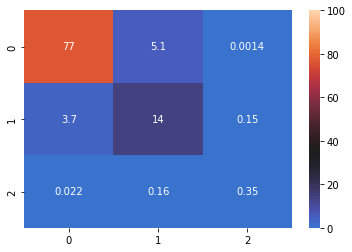

In [7]:
# Predict and evaluate the model for the tsubsi process
y_pred_model_tsubsi = rf_classifier_tsubsi.predict(X_test_tsubsi)
cm = rf_functions.get_confmat_clasreport(y_test_tsubsi, y_pred_model_tsubsi, model='Test')

sns.heatmap(cm*100/np.sum(cm), annot=True, center=35,vmax=100,vmin=0)

---

---


In [21]:
class_weights = {0:1, 1:2, 2:10}
# Train forest for the tsubsi
rf_tsubsi_new = RandomForestClassifier(n_estimators=550,
                                              criterion='gini', 
                                              max_depth=7,
                                              max_features= 'sqrt',                         # 'sqrt',          # The number of features to consider when looking for the best split
                                              oob_score=True,
                                              verbose=0,
                                              n_jobs=-1,
                                              class_weight= class_weights,                #class_weights,   #balanced , balanced_subsample,
                                              random_state=42)
# Parameters that are not listed: "min_samples_split", "min_samples_leaf", "min_weight_fraction_leaf", "max_leaf_nodes", "min_impurity_decrease", "bootstrap", 

# Fit Forest
rf_tsubsi_new.fit(X_train_tsubsi, y_train_tsubsi)

RandomForestClassifier(class_weight={0: 1, 1: 2, 2: 10}, max_depth=7,
                       max_features='sqrt', n_estimators=550, n_jobs=-1,
                       oob_score=True, random_state=42)

============================  Test  ============================
Confusion matrix:
[[276228  25719      7]
 [ 14807  50161    561]
 [   138    853    981]]

	------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93    301954
         1.0       0.65      0.77      0.71     65529
         2.0       0.63      0.50      0.56      1972

    accuracy                           0.89    369455
   macro avg       0.75      0.73      0.73    369455
weighted avg       0.89      0.89      0.89    369455



<AxesSubplot:>

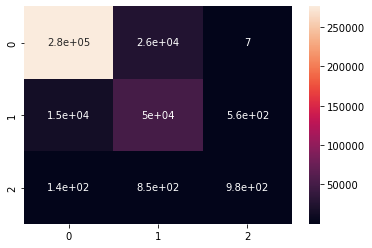

In [22]:
# Predict and evaluate the model for the tsubsi process
y_pred_model = rf_tsubsi_new.predict(X_test_tsubsi)
cm = rf_functions.get_confmat_clasreport(y_test_tsubsi, y_pred_model, model='Test')

sns.heatmap(cm, annot=True)

In [23]:
feature_list = ['SIWC', 'RH_ifs', 'Temp', 'CC', 'W']

# Get numerical feature importances
importances = list(rf_tsubsi_new.feature_importances_)# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: SIWC                 Importance: 0.4
Variable: Temp                 Importance: 0.25
Variable: CC                   Importance: 0.17
Variable: RH_ifs               Importance: 0.11
Variable: W                    Importance: 0.07


[None, None, None, None, None]

In [24]:
## Save random forest classifier

path = '/home/freimax/msc_thesis/scripts/random_forest/models'
with open(f'{path}/rf_classifier_tsubsi.pickle', 'wb') as f:
    pickle.dump(rf_classifier_tsubsi, f)

In [25]:
get_tree=False
if get_tree:
    # Import tools needed for visualization
    from sklearn.tree import export_graphviz
    import graphviz
    from IPython.display import Image
    # Pull out one tree from the forest
    tree = rf_classifier_tsubsi.estimators_[5]
    dot_data = export_graphviz(tree, filled=True, rounded=True, special_characters=True)
    graph = graphviz.Source(dot_data)

    # Display the graph
    #display(graph)
    path='/home/freimax/msc_thesis/figures/case_study_RA19/rf_trees'
    graph.render(filename=f'{path}/decision_tree.png', cleanup=True)

---
---
## Apply random forest on different timesteps

In [8]:
ds_p_all = xr.open_mfdataset('/net/thermo/atmosdyn2/atroman/PACaccu/cdf/P*')
ds_p_all = ds_p_all.squeeze('lev2')
da_rh = xr.open_dataset('/home/freimax/msc_thesis/data/case_study_ra19/model_level_coord/RH_ifs.nc')

lonrange = [135,-165]
latrange = [20,70]
ds_p = get_lonlatbox(ds_p_all, lon_range=lonrange, lat_range=latrange)

ds_p['tsubsi']  = ds_p['tsubs'] + ds_p['tsubi']
ds_p['tmeltsi'] = ds_p['tmelts']+ ds_p['tmelti']
ds_p['SIWC']    = ds_p['SWC']+ ds_p['IWC']

In [16]:
### Select time frame for verification
ds_p_t1 = ds_p.isel(time=slice(50,55))
da_rh_t1 = da_rh.isel(time=slice(50,55))
ds_p_t1['RH_ifs'] = da_rh_t1['RH_ifs']

In [26]:
model = rf_tsubsi_new


## Get a data-array with the predicitons
print('Make random forest predictions')
da_y_pred_tsubsi = rf_functions.predict_bcp_labels(ds_p_t1, model, type_filteredvalues='zero')
da_y_pred_tsubsi_binary = da_y_pred_tsubsi.where(da_y_pred_tsubsi != 2, 1) 
np_y_pred_tsubsi = da_y_pred_tsubsi.values.flatten()
np_y_pred_tsubsi_binary = da_y_pred_tsubsi_binary.values.flatten()

Make random forest predictions

Predict labels using random forest
-------------------------------------------------------------------------------------------------------------
Create df_features
	Drop SIWC == 0 from df_features
Drop all points where SIWC == 0

Scale Temperature values
Applying z-scaling...
               SIWC        RH_ifs          Temp            CC             W
count  1.987824e+06  1.987824e+06  1.987824e+06  1.987824e+06  1.987824e+06
mean   3.532898e-02  8.153168e-01  3.421228e-07  2.950040e-01 -6.660067e-02
std    8.685433e-02  2.250202e-01  9.995693e-01  3.718421e-01  2.688485e-01
min    9.313226e-07  3.189810e-03 -3.746635e+00  0.000000e+00 -4.570383e+00
25%    7.897615e-04  7.243791e-01 -5.829649e-01  0.000000e+00 -1.365473e-01
50%    5.438924e-03  8.900676e-01  2.953335e-01  7.031250e-02 -1.748085e-02
75%    2.557412e-02  9.798516e-01  7.932887e-01  6.171875e-01  6.431162e-02
max    2.879463e+00  1.510450e+00  1.706671e+00  1.000000e+00  2.032690e+00


Ouput

In [27]:
## Get the Ground-truth values
print('Get the true labels for the bcp-processes')
da_y_true_tsubsi = rf_functions.get_y_true(data_array=ds_p_t1.tsubsi, thresholds={'weak':-0.075,'medium':-0.75})
np_y_true_tsubsi = da_y_true_tsubsi.values.flatten()
da_y_true_tsubsi_binary = da_y_true_tsubsi.where(da_y_true_tsubsi != 2, 1) 
np_y_true_tsubsi_binary  = da_y_true_tsubsi_binary.values.flatten()


## Get the Baseline predictions
print('Get the true labels for the bcp-processes')
da_y_baseline_tsubsi = rf_functions.get_y_baseline(input_data=ds_p_t1, bcp='tsubsi', thr_vars=['SIWC','RH_ifs'], thr_metrics = '50%')
np_y_baseline_tsubsi = da_y_baseline_tsubsi.values.flatten()


Get the true labels for the bcp-processes
Get the true labels for the bcp-processes


In [28]:
a=rf_functions.get_confmat_clasreport(np_y_true_tsubsi_binary, np_y_pred_tsubsi_binary, model='RandomForest')
a=rf_functions.get_confmat_clasreport(np_y_true_tsubsi_binary, np_y_baseline_tsubsi   , model='Baseline')


============================  RandomForest  ============================
Confusion matrix:
[[7438245  138292]
 [  61895  205068]]

	------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99   7576537
         1.0       0.60      0.77      0.67    266963

    accuracy                           0.97   7843500
   macro avg       0.79      0.87      0.83   7843500
weighted avg       0.98      0.97      0.98   7843500

============================  Baseline  ============================
Confusion matrix:
[[7138812  437725]
 [  70274  196689]]

	------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.97   7576537
         1.0       0.31      0.74      0.44    266963

    accuracy                           0.94   7843500
   macro avg       0.65    

In [29]:
## Print classification report only for RF-model (with 3 classes)
a=rf_functions.get_confmat_clasreport(np_y_true_tsubsi, np_y_pred_tsubsi, model='RandomForest')

============================  RandomForest  ============================
Confusion matrix:
[[7438245  138243      49]
 [  61103  197080    2632]
 [    792    2907    2449]]

	------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99   7576537
         1.0       0.58      0.76      0.66    260815
         2.0       0.48      0.40      0.43      6148

    accuracy                           0.97   7843500
   macro avg       0.68      0.71      0.69   7843500
weighted avg       0.98      0.97      0.98   7843500



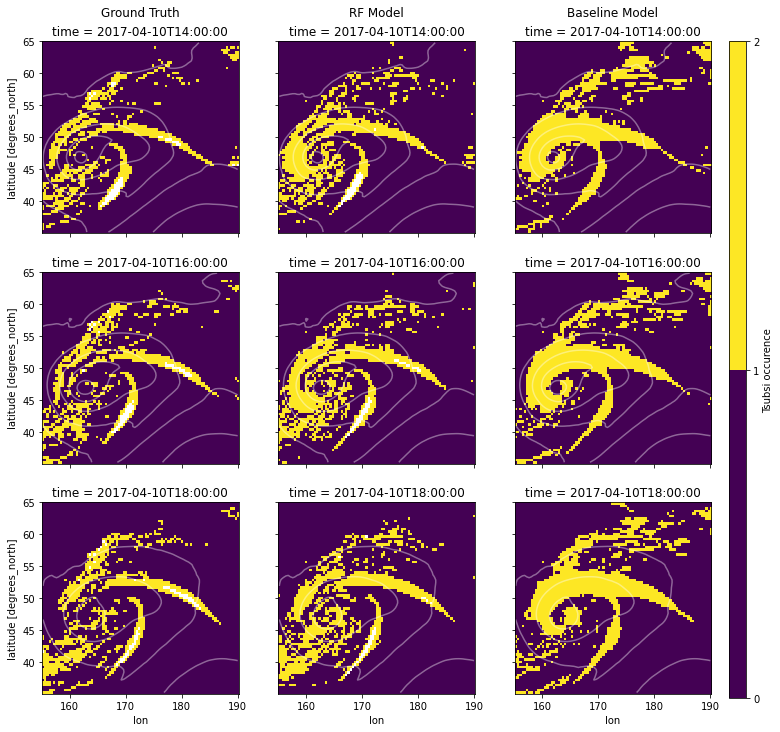

In [30]:
level = 20
#level = 'sum'

lon_min = 155
lon_max = 190

lat_min = 35
lat_max = 65 
#--------------------------------------------------------------------------------
if level == 'sum':
    y_abstruth = da_y_true_tsubsi.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max)).sum(dim='lev')
    y_baseline = da_y_baseline_tsubsi.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max)).sum(dim='lev')
    y_rf_model = da_y_pred_tsubsi.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max)).sum(dim='lev')
    da_slp     = ds_p_t1.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
elif isinstance(level, int) :
    y_abstruth = da_y_true_tsubsi.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max), lev=level)
    y_baseline = da_y_baseline_tsubsi.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max), lev=level)
    y_rf_model = da_y_pred_tsubsi.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max), lev=level)
    da_slp     = ds_p_t1.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

# Get the middle timestep
middle_timestep = da_y_true_tsubsi.time.size // 2
# Extract and slice the DataArrays for each timestep
timesteps = [0, middle_timestep, -1]

data_arrays = [
    [y_abstruth.isel(time=t) for t in timesteps],
    [y_rf_model.isel(time=t) for t in timesteps], 
    [y_baseline.isel(time=t) for t in timesteps], 
               ]
slp_array=[da_slp.SLP.isel(time=t) for t in timesteps]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), sharex=True, sharey=True)
titles = ['Ground Truth', 'RF Model', 'Baseline Model', ]
for col, data_row in enumerate(data_arrays):
    for row, data in enumerate(data_row):
        ax = axes[row][col]
        # Plot the data
        im = data.plot.imshow(ax=ax, add_colorbar=False, add_labels=True, levels=[0,1,2 ])
        slp_array[row].plot.contour(ax=ax, colors='white', alpha=0.4)
        # Remove labels from the internal axes
        if col != 0:
            ax.set_ylabel('')
        if row != (axes.shape[0]-1):
            ax.set_xlabel('')

for idx, title in enumerate(titles):
    axes[0][idx].text(0.5, 1.15, title, transform=axes[0][idx].transAxes, ha='center', va='center', fontsize=12)


# Add a shared colorbar
cax = fig.add_axes([0.92, 0.12, 0.02, 0.76])
cb = plt.colorbar(im, cax=cax)
cb.set_label('Tsubsi occurence')


mid_time = da_y_true_tsubsi.isel(time=middle_timestep).time
formatted_date = pd.to_datetime(mid_time.values).strftime('%Y-%m-%d')
time2 = da_y_true_tsubsi.isel(time=0).time.values

time_diff = pd.to_timedelta(mid_time.values - time2)
time_diff_in_hours = time_diff.total_seconds() / 3600
path = '/home/freimax/msc_thesis/figures/case_study_RA19/RF_classification'
#plt.savefig(f'{path}/verification_around_t{formatted_date}_dt{time_diff_in_hours}h_at_lev{level}.png', dpi=250)
plt.show()